In [1]:
import pytesseract
from PIL import Image
import pandas as pd
import numpy as np
import re
from scipy.spatial import distance
import datefinder
import nltk
from nltk.tag.stanford import StanfordNERTagger
import os
from flair.models import SequenceTagger
from flair.data import Sentence
import cv2
import matplotlib.pyplot as plt
import tempfile

In [964]:
tagger = SequenceTagger.load('ner')
#tagger = SequenceTagger.load('ner')

2019-08-28 12:47:23,171 loading file C:\Users\suman\.flair\models\en-ner-conll03-v0.4.pt


In [3]:
pd.options.display.max_columns = 100

In [804]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [805]:
def set_image_dpi(file_path):
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

In [806]:
def remove_isolated_pixels(dirty):
    dirty_inverse = cv2.bitwise_not(dirty)
    kernel1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]], np.uint8)
    kernel2 = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]], np.uint8)

    hitormiss1 = cv2.morphologyEx(dirty, cv2.MORPH_ERODE, kernel1)
    hitormiss2 = cv2.morphologyEx(dirty_inverse, cv2.MORPH_ERODE, kernel2)
    # The following variable will contain the isolated pixels.
    isolated_pixels = cv2.bitwise_and(hitormiss1, hitormiss2)
    # To remove them from the original image we can invert this to use it as a mask for a bitwise and operation.
    isolated_pixels_inverse = cv2.bitwise_not(isolated_pixels)
    clean = cv2.bitwise_and(dirty, dirty, mask=isolated_pixels_inverse)
    return clean

In [807]:
def remove_noise_and_smooth(file_name):
    img = cv2.imread(file_name, 0)
    isolated = remove_isolated_pixels(img)
    blur = cv2.GaussianBlur(isolated, (1,1), 0)
    #filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 13)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    or_image = cv2.bitwise_or(img, closing)
    #erode = cv2.erode(or_image, np.ones((2, 2)))
    #dilate = cv2.dilate(erode, np.ones((2, 2)))
    return or_image

Image size: (468, 624)


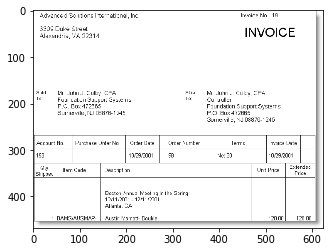

In [875]:
image_path = r'F:\Datasets\Table Detection\images\Invoice.png'
new_file = set_image_dpi(image_path)
img = remove_noise_and_smooth(new_file)
plt.imshow(img, cmap='gray')
plt.imsave(r'F:\Datasets\Table Detection\images\Invoice temp.png', img, cmap='gray')
print("Image size: {}".format(img.shape))

In [876]:
img_data = pytesseract.image_to_data(img)
print("Image data has {} rows".format(len(img_data)))

Image data has 7618 rows


In [877]:
img_data_list = img_data.replace('\t', " ").split("\n")

In [878]:
img_data_list_copy = []

In [879]:
for i in range(1, len(img_data_list)):
    temp_list = img_data_list[i].split()
    if len(temp_list) == 11:
        temp_list.append("")
    img_data_list_copy.append(temp_list)

In [880]:
image_ocr_df = pd.DataFrame(img_data_list_copy)

In [881]:
image_ocr_df.columns = ['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text']

In [882]:
image_ocr_df[['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf']] = image_ocr_df[['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf']].astype('int')

In [883]:
image_ocr_df.columns = img_data_list[0].split()

In [884]:
image_ocr_df_new = image_ocr_df[image_ocr_df['conf'] > 0]
image_ocr_df_new["text"] = image_ocr_df_new["text"].apply(lambda x: x.strip())
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != ""]
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "|"]
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "-"]
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "."]
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "#"]
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "—"]
image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "—"]
#image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "*"]
#image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "="]
#image_ocr_df_new = image_ocr_df_new[image_ocr_df_new["text"] != "~"]

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Resetting index and copying to new dataframe

In [885]:
image_ocr_df_new_reset_index = image_ocr_df_new.reset_index(drop=True)

### Adding text len column and average character width

In [886]:
#Findig max of each value on each page
max_values_by_page = image_ocr_df_new_reset_index.groupby(by='page_num').max()
min_values_by_page = image_ocr_df_new_reset_index.groupby(by='page_num').min()
image_ocr_df_new_reset_index["text_len"] = image_ocr_df_new_reset_index["text"].apply(lambda x:len(x))
#Creating avg_character_width
image_ocr_df_new_reset_index["avg_char_width"] = image_ocr_df_new_reset_index["width"]/image_ocr_df_new_reset_index["text_len"]

### Generating self defined line_number ir-respective of block, page etc.

In [887]:
temp_df = image_ocr_df_new_reset_index[['level', 'page_num', 'block_num', 'par_num', 'line_num']].drop_duplicates().reset_index(drop=True).reset_index(drop=False)
temp_df = temp_df.rename(columns={"index":"custom_line_num"})
image_ocr_df_new_reset_index = pd.merge(image_ocr_df_new_reset_index, temp_df, on=['level', 'page_num', 'block_num', 'par_num', 'line_num'])

### Fixing cases where width is unexpected and left + width < next line's left

In [888]:
image_ocr_df_new_reset_index["custom_width"] = image_ocr_df_new_reset_index["width"]
for i in range(1, len(image_ocr_df_new_reset_index)-1):
    if image_ocr_df_new_reset_index["left"][i] + image_ocr_df_new_reset_index["width"][i] > image_ocr_df_new_reset_index["left"][i+1]:
        if image_ocr_df_new_reset_index["custom_line_num"][i-1] == image_ocr_df_new_reset_index["custom_line_num"][i+1]:
            mean_value_next_prev_width_by_len = np.mean(np.array([image_ocr_df_new_reset_index["avg_char_width"][i-1], image_ocr_df_new_reset_index["avg_char_width"][i+1]]))
            if image_ocr_df_new_reset_index['custom_width'][i] / image_ocr_df_new_reset_index['text_len'][i] > mean_value_next_prev_width_by_len:
                image_ocr_df_new_reset_index.at[i,'custom_width'] = min(mean_value_next_prev_width_by_len * image_ocr_df_new_reset_index['text_len'][i], (image_ocr_df_new_reset_index["left"][i+1] - image_ocr_df_new_reset_index["left"][i])) 

### Getting distance between each word in same line

In [889]:
image_ocr_df_new_reset_index.sort_values(by=['custom_line_num', 'left'], inplace=True)

In [890]:
image_ocr_df_new_reset_index["dist_bw_words_l2r"] = 0.00
for i in range(1,len(image_ocr_df_new_reset_index)):
    if image_ocr_df_new_reset_index["custom_line_num"][i] == image_ocr_df_new_reset_index["custom_line_num"][i-1]:
        curr_left = image_ocr_df_new_reset_index["left"][i]
        prev_left = image_ocr_df_new_reset_index["left"][i-1]
        prev_width = image_ocr_df_new_reset_index["custom_width"][i-1]
        image_ocr_df_new_reset_index.at[i,"dist_bw_words_l2r"] = max(0,curr_left - (prev_left + prev_width))
median_dist_bw_words = np.median(image_ocr_df_new_reset_index["dist_bw_words_l2r"])
mean_dist_bw_words = np.mean(image_ocr_df_new_reset_index["dist_bw_words_l2r"])
print("Mean average distance between each word in same line is - " + str(mean_dist_bw_words))
print("Median average distance between each word in same line is - " + str(median_dist_bw_words))

Mean average distance between each word in same line is - 34.37777777777778
Median average distance between each word in same line is - 5.0


In [891]:
image_ocr_df_new_reset_index[0:20]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,text_len,avg_char_width,custom_line_num,custom_width,dist_bw_words_l2r
0,5,1,2,1,1,1,15,7,58,10,70,‘Advanced,9,6.444444,0,58,0.0
1,5,1,2,1,1,2,77,7,53,10,95,Solutions,9,5.888889,0,53,4.0
2,5,1,2,1,1,3,134,7,72,12,65,"Intemational,",13,5.538462,0,72,4.0
3,5,1,2,1,1,4,211,7,15,10,90,Inc.,4,3.750000,0,15,5.0
4,5,1,2,1,1,5,448,7,37,9,20,Invoice,7,5.285714,0,37,222.0
5,5,1,2,1,1,6,489,7,14,9,94,No.,3,4.666667,0,14,4.0
6,5,1,2,1,1,7,515,7,12,9,84,19,2,6.000000,0,12,12.0
7,5,1,4,1,1,1,15,35,29,11,91,3309,4,7.250000,1,29,0.0
8,5,1,4,1,1,2,49,35,29,11,96,Duke,4,7.250000,1,29,5.0
9,5,1,4,1,1,3,83,35,35,11,81,Street,6,5.833333,1,35,5.0


### Fixing cases where height is unexpected

In [892]:
image_ocr_df_new_reset_index["custom_height"] = image_ocr_df_new_reset_index["height"]
special_chars = [',','.','/','@','$','%','^','&','*','(',')','!','~','?','}','{']
average_height = np.mean(image_ocr_df_new_reset_index["height"])
for i in range(1, len(image_ocr_df_new_reset_index)-1):
    if image_ocr_df_new_reset_index["height"][i] > 1.5*average_height:
        if image_ocr_df_new_reset_index["avg_char_width"][i] < 2*np.mean(image_ocr_df_new_reset_index["avg_char_width"]):
            if image_ocr_df_new_reset_index["custom_line_num"][i-1] == image_ocr_df_new_reset_index["custom_line_num"][i+1]:
                if (image_ocr_df_new_reset_index["dist_bw_words_l2r"][i] < median_dist_bw_words*2) and (image_ocr_df_new_reset_index["dist_bw_words_l2r"][i+1] < median_dist_bw_words*2):
                    if image_ocr_df_new_reset_index["height"][i-1] < 1.5*average_height and image_ocr_df_new_reset_index["height"][i+1] < 1.5*average_height:
                        mean_next_prev_height = np.mean(np.array([image_ocr_df_new_reset_index["height"][i-1], image_ocr_df_new_reset_index["height"][i+1]]))
                        image_ocr_df_new_reset_index.at[i,'custom_height'] = mean_next_prev_height

### Defining co-ordinates of each word and internal euclidean distance

In [893]:
image_ocr_df_new_reset_index["diagonal_text_coordinates"] = ""
image_ocr_df_new_reset_index["bottom_left_coordinates"] = ""
image_ocr_df_new_reset_index["Internal_Euclidean_Distance"] = 0.00
image_ocr_df_new_reset_index["word_density"] = 0.00
for i in range(len(image_ocr_df_new_reset_index)):
    image_ocr_df_new_reset_index.at[i,"diagonal_text_coordinates"] = [(image_ocr_df_new_reset_index["left"][i], image_ocr_df_new_reset_index["top"][i]), (image_ocr_df_new_reset_index["left"][i] + image_ocr_df_new_reset_index["custom_width"][i], image_ocr_df_new_reset_index["top"][i] + image_ocr_df_new_reset_index["custom_height"][i])]
    image_ocr_df_new_reset_index.at[i,"bottom_left_coordinates"] = [(image_ocr_df_new_reset_index["left"][i], image_ocr_df_new_reset_index["top"][i]-image_ocr_df_new_reset_index["custom_height"][i])]
    image_ocr_df_new_reset_index.at[i,"Internal_Euclidean_Distance"] = np.linalg.norm(np.array(image_ocr_df_new_reset_index["diagonal_text_coordinates"][i][0]) - np.array(image_ocr_df_new_reset_index["diagonal_text_coordinates"][i][1]))
    image_ocr_df_new_reset_index.at[i,"word_density"] = image_ocr_df_new_reset_index["Internal_Euclidean_Distance"][i]/image_ocr_df_new_reset_index["text_len"][i]

### Defining tags of words

In [894]:
months_of_year = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'january', 'february', 'march',
        'april', 'May', 'june', 'july', 'august', 'september', 'october', 'november','december']

In [895]:
image_ocr_df_new_reset_index["Heading"] = 0
image_ocr_df_new_reset_index["Main Heading"] = 0
image_ocr_df_new_reset_index["Number"] = 0
image_ocr_df_new_reset_index["AlphaNumeric"] = 0
image_ocr_df_new_reset_index["Date"] = 0
image_ocr_df_new_reset_index["Month"] = 0
image_ocr_df_new_reset_index["Location"] = 0
image_ocr_df_new_reset_index["Currency"] = 0
mean_word_density = np.mean(image_ocr_df_new_reset_index["word_density"])
for i in range(len(image_ocr_df_new_reset_index)):
    if image_ocr_df_new_reset_index["text_len"][i] > 2 and image_ocr_df_new_reset_index["word_density"][i] > mean_word_density:
        image_ocr_df_new_reset_index.at[i,"Heading"] = 1
    if image_ocr_df_new_reset_index["text_len"][i] > 2 and image_ocr_df_new_reset_index["word_density"][i] > mean_word_density*2:
        image_ocr_df_new_reset_index.at[i,"Main Heading"] = 1
    if image_ocr_df_new_reset_index["text"][i].lower().strip() in months_of_year:
        image_ocr_df_new_reset_index.at[i,"Month"] = 1
    try:
        if float(image_ocr_df_new_reset_index["text"][i])/1 == float(image_ocr_df_new_reset_index["text"][i])/1:
            image_ocr_df_new_reset_index.at[i,"Number"] = 1
    except:
        pass
    try:
        only_alphabets = re.sub('[0-9]', '', image_ocr_df_new_reset_index["text"][i])
        only_numbers = re.sub('[a-z]', '', only_alphabets.lower())
        if len(only_alphabets) < image_ocr_df_new_reset_index["text_len"][i] and len(only_alphabets) > 0 and len(only_numbers) == 0:
            image_ocr_df_new_reset_index.at[i,"AlphaNumeric"] = 1
    except:
        pass
    try:
        date_matcher = datefinder.find_dates(image_ocr_df_new_reset_index["text"][i])
        if len(list(date_matcher)) > 0:
            image_ocr_df_new_reset_index.at[i,"Date"] = 1
    except:
        pass        
print("Mean word density is - " + str(mean_word_density))

Mean word density is - 6.487484348470814


# Identifying block of information from left to right

In [896]:
def check_numeric_or_date_exists(text):
    text = text.strip()
    try:
        if float(text)/1 == float(text)/1:
            return 1
    except:
        pass
    
    try:
        date_matcher = datefinder.find_dates(text)
        if len(list(date_matcher)) > 0:
            return 1
    except:
        pass   
    
    try:
        only_alphabets = re.sub('[0-9]', '', text)
        only_numbers = re.sub('[a-z]', '', only_alphabets.lower())
        if len(only_alphabets) < len(text) and len(only_alphabets) > 0 and len(only_numbers) == 0:
            return 1  
    except:
        pass
    
    try:
        only_alphabets = re.sub('[0-9]', '', text)
        if len(text) - len(only_alphabets) > 0:
            return 1
    except:
        pass
        
    return 0

In [897]:
median_external_word_dst_big_line = np.median(image_ocr_df_new_reset_index["dist_bw_words_l2r"])
mean_external_word_dst_big_line = np.mean(image_ocr_df_new_reset_index["dist_bw_words_l2r"])
double_median_external_word_dst_big_line = median_external_word_dst_big_line*2.2
double_mean_external_word_dst_big_line = mean_external_word_dst_big_line*2.2
print("Twice of median distance between each word is - " + str(double_median_external_word_dst_big_line))
print("Twice of mean distance between each word is - " + str(double_mean_external_word_dst_big_line))
if double_median_external_word_dst_big_line == 0 or double_median_external_word_dst_big_line > double_mean_external_word_dst_big_line:
    double_median_external_word_dst_big_line = double_mean_external_word_dst_big_line

Twice of median distance between each word is - 11.0
Twice of mean distance between each word is - 75.63111111111112


#### IF FROM LEFT TO RIGHT, A HUGE GAP IS FOUND BETWEEN WORDS THEN IT MAY BE A BLOCK OF INFORMATION BUT NOT FIRST WORD

In [898]:
image_ocr_df_info_block = image_ocr_df_new_reset_index.drop(columns=['level', 'page_num', 'block_num', 'par_num', 'line_num', 'Heading', 'Main Heading', 'Number', 'AlphaNumeric', 'Date', 'Month', 'Location', 'Currency'])
image_ocr_df_info_block["L2R Block of information"] = 0
image_ocr_df_info_block["L2R BOI_NotFirstWord"] = 0
image_ocr_df_info_block["L2R BOI_FirstWordPrevLineBOI"] = 0
image_ocr_df_info_block["L2R BOI_FirstWordHaveGapinRightButWordExists"] = 0
image_ocr_df_info_block["L2R BOI_FoundColonHyphen"] = 0

In [899]:
#WHEN IT IS NOT THE FIRST WORD OF LINE BUT WORD DISTANCE IS GREATER THAN MEAN, MARK AS INFO BLOCK
for i in range(1, len(image_ocr_df_info_block)):
    #if image_ocr_df_info_block["Euc_dist_bw_words"][i] > mean_external_euclidean_distance and image_ocr_df_info_block["line_num"][i] == image_ocr_df_info_block["line_num"][i-1]:
    if image_ocr_df_info_block["dist_bw_words_l2r"][i] >  double_median_external_word_dst_big_line and image_ocr_df_info_block["custom_line_num"][i] == image_ocr_df_info_block["custom_line_num"][i-1]:
        image_ocr_df_info_block.at[i, "L2R Block of information"] = 1
        image_ocr_df_info_block.at[i, "L2R BOI_NotFirstWord"] = 1            

In [900]:
image_ocr_df_info_block.head(2)

,word_num,left,top,width,height,conf,text,text_len,avg_char_width,custom_line_num,custom_width,dist_bw_words_l2r,custom_height,diagonal_text_coordinates,bottom_left_coordinates,Internal_Euclidean_Distance,word_density,L2R Block of information,L2R BOI_NotFirstWord,L2R BOI_FirstWordPrevLineBOI,L2R BOI_FirstWordHaveGapinRightButWordExists,L2R BOI_FoundColonHyphen
0,1,15,7,58,10,70,‘Advanced,9,6.444444,0,58,0.0,10,"[(15, 7), (73, 17)]","[(15, -3)]",58.855756,6.539528,0,0,0,0,0
1,2,77,7,53,10,95,Solutions,9,5.888889,0,53,4.0,10,"[(77, 7), (130, 17)]","[(77, -3)]",53.935146,5.992794,0,0,0,0,0


#### FIRST WORD BUT PREVIOUS LINE HAS BLOCK OF INFORMATION STARTING AT SAME LEFT POSITION

In [901]:

#WHEN IT IS THE FIRST WORD OF LINE AND PREVIOUS LINE HAS INFO BLOCK STARTING AT NEAR ABOUT SIMILAR POSITION, MARK AS INFO BLOCK
#For NOW ONLY IN SAME BLOCK, LATER ADD FUNC TO SKIP BLOCK AS WELL
#all_blocks = list(set(list(image_ocr_df_info_block["block_num"])))
for i in range(1, len(image_ocr_df_info_block)):
    if image_ocr_df_info_block["word_num"][i] == 1 and image_ocr_df_info_block["custom_line_num"][i] == image_ocr_df_info_block["custom_line_num"][i-1]+1:
    #if image_ocr_df_info_block["par_num"][i] == image_ocr_df_info_block["par_num"][i-1]:
        prev_line_max_words = image_ocr_df_info_block["word_num"][i-1]
        temp_df = image_ocr_df_info_block.iloc[i-prev_line_max_words:i,:]
        temp_df_list = list(temp_df[temp_df["L2R Block of information"] == 1]["left"])
        left_position_of_first_word = image_ocr_df_info_block["left"][i]
        for x in range(left_position_of_first_word-3, left_position_of_first_word+4):
            #print(temp_df_list)
            #print(x)
            if x in temp_df_list:
                image_ocr_df_info_block.at[i, "L2R Block of information"] = 1
                image_ocr_df_info_block.at[i, "L2R BOI_FirstWordHaveGapinRightButWordExists"] = 1

In [902]:
image_ocr_df_info_block_copy = image_ocr_df_info_block.copy()

### Identifying cases where block of information starts from first word of the line and there is other text in right too

In [903]:

for line in list(set(image_ocr_df_info_block_copy["custom_line_num"])):
    counter_word = []
    counter_fw_wir = 1
    temp_df = image_ocr_df_info_block_copy[image_ocr_df_info_block_copy["custom_line_num"] == line]
    temp_df_index = list(temp_df.index.values)
    for i, ind in enumerate(temp_df_index):
        if i < len(temp_df_index)-1:
            counter_word.append(ind)
            if temp_df["dist_bw_words_l2r"][ind+1] > double_median_external_word_dst_big_line:
                for cw in counter_word:
                    temp_df.at[cw, "L2R Block of information"] = 1
                    temp_df.at[cw, "L2R BOI_FirstWordHaveGapinRightButWordExists"] = counter_fw_wir
                    counter_fw_wir+=1
                break
                counter_word = []
                
    image_ocr_df_info_block_copy[image_ocr_df_info_block_copy["custom_line_num"] == line]  = temp_df

### Identifying cases where block of information starts from first word of the line and it is the only text in line

In [904]:
width_of_image = img.shape[1]
max_left_value_in_image = max(image_ocr_df_info_block_copy.left)
print(max_left_value_in_image, width_of_image)

563 624


In [905]:
def return_words_left_right_same_line(image_ocr_df_info_block_copy, line):
    temp_df = image_ocr_df_info_block_copy[image_ocr_df_info_block_copy["custom_line_num"] == line]
    temp_df_index = list(temp_df.index.values)

    max_word_of_line = max(temp_df.word_num)
    min_word_of_line = min(temp_df.word_num)

    temp_small_set_max = temp_df[temp_df["word_num"] == max_word_of_line]
    temp_left_max = int(temp_small_set_max.left.values)
    temp_height_max = int(temp_small_set_max.custom_height.values)
    temp_top_max = int(temp_small_set_max.top.values)

    temp_small_set_min = temp_df[temp_df["word_num"] == min_word_of_line]
    temp_left_min = int(temp_small_set_min.left.values)
    temp_height_min = int(temp_small_set_min.custom_height.values)
    temp_top_min = int(temp_small_set_min.top.values)

    another_df_temp_max = image_ocr_df_info_block_copy[(image_ocr_df_info_block_copy["left"] > temp_left_max) & (image_ocr_df_info_block_copy["top"] - image_ocr_df_info_block_copy["height"] < temp_top_max) & (temp_top_max - temp_height_max <  image_ocr_df_info_block_copy["top"])]
    another_df_temp_min = image_ocr_df_info_block_copy[(image_ocr_df_info_block_copy["left"] < temp_left_min) & (image_ocr_df_info_block_copy["top"] - image_ocr_df_info_block_copy["height"] < temp_top_min) & (temp_top_min - temp_height_min <  image_ocr_df_info_block_copy["top"])]
    return another_df_temp_max, another_df_temp_min, temp_df

In [906]:
#Where there is no additional gap in words and first the whole line is less than 50% of max width in whole image
image_ocr_df_info_block_copy["L2R BOI_FirstWordButTheOnlyTextInLine"] = 0
counter_fw_nir = 1
for line in list(set(image_ocr_df_info_block_copy["custom_line_num"])):
    another_df_temp_max, another_df_temp_min, temp_df  = return_words_left_right_same_line(image_ocr_df_info_block_copy, line)
    counter_word = []
    if len(another_df_temp_max) == 0 and len(another_df_temp_min) == 0:
        total_width = sum(temp_df["width"])
        #print(total_width)
        if total_width < max_left_value_in_image*.5:
            temp_df_index = list(temp_df.index.values)
            #print(temp_df_index)
            for i, ind in enumerate(temp_df_index):
                #print(i, ind)
                if i < len(temp_df_index)-1:
                    if temp_df["dist_bw_words_l2r"][ind+1] > double_median_external_word_dst_big_line:
                        break
                    else:
                        counter_word.append(ind)
                else:
                    counter_word.append(ind)
                    for cw in counter_word:
                        temp_df.at[cw, "L2R Block of information"] = 1
                        temp_df.at[cw, "L2R BOI_FirstWordButTheOnlyTextInLine"] = counter_fw_nir
                        counter_fw_nir += 1
                    counter_word = []
            image_ocr_df_info_block_copy[image_ocr_df_info_block_copy["custom_line_num"] == line]  = temp_df

### Cases where not enough distance but -, :, # exists in word and there is value after special character

In [907]:
for i in range(1, len(image_ocr_df_info_block_copy)):
    if image_ocr_df_info_block_copy["L2R Block of information"][i] == 0:
        special_chars = [":", "-", "#"]
        special_char_exists = 0
        #this_special_char = ""
        for sc in special_chars:
            if sc in image_ocr_df_info_block_copy["text"][i-1]:
                special_char_exists = 1
                this_special_char = sc
                break
        
        if (special_char_exists == 1) and (image_ocr_df_info_block_copy["custom_line_num"][i] == image_ocr_df_info_block_copy["custom_line_num"][i-1]) and (image_ocr_df_info_block_copy["dist_bw_words_l2r"][i] <= double_median_external_word_dst_big_line) and (image_ocr_df_info_block_copy["L2R Block of information"][i] == 0):
            text_temp = str(image_ocr_df_info_block_copy["text"][i-1]).strip()
            text_i = image_ocr_df_info_block_copy["text"][i]
            temp_line_num = image_ocr_df_info_block_copy["custom_line_num"][i]
            temp_word_num = image_ocr_df_info_block_copy["word_num"][i]
            if text_temp[len(text_temp)-1:len(text_temp)] == this_special_char:
                if check_numeric_or_date_exists(text_i) == 1 and check_numeric_or_date_exists(text_temp) == 0:     
                    image_ocr_df_info_block_copy.at[i, "L2R Block of information"] = 1
                    image_ocr_df_info_block_copy.at[i, "L2R BOI_FoundColonHyphen"] = 990
                    
                    #Combining words on left
                    temp_df = image_ocr_df_info_block_copy[(image_ocr_df_info_block_copy["custom_line_num"] == temp_line_num) & (image_ocr_df_info_block_copy["word_num"] < temp_word_num)]
                    counter = 1    
                    if len(temp_df) == 1:
                        temp_df.at[i-1, "L2R Block of information"] = 1
                        temp_df.at[i-1, "L2R BOI_FoundColonHyphen"] = 1
                    else:
                        for xx in reversed(range(len(temp_df["dist_bw_words_l2r"]))):
                            if temp_df.iloc[xx,:]["dist_bw_words_l2r"] <= double_median_external_word_dst_big_line and check_numeric_or_date_exists(temp_df.iloc[xx,:]["text"]) == 0:
                                counter += 1
                            else:
                                break
                        new_counter = 1
                        for yy in reversed(range(counter)):
                            temp_df.at[i-yy, "L2R Block of information"] = 1
                            temp_df.at[i-yy, "L2R BOI_FoundColonHyphen"] = new_counter
                            new_counter += 1
                    image_ocr_df_info_block_copy[(image_ocr_df_info_block_copy["custom_line_num"] == temp_line_num) & (image_ocr_df_info_block_copy["word_num"] < temp_word_num)] = temp_df
            
                    #Combining words on right
                    temp_df2 = image_ocr_df_info_block_copy[(image_ocr_df_info_block_copy["custom_line_num"] == temp_line_num) & (image_ocr_df_info_block_copy["word_num"] > temp_word_num)]

                    if len(temp_df2) > 0:
                        val_counter = 990
                        index_counter = 0
                        for xx in range(len(temp_df2)):
                            if temp_df2.iloc[xx,:]["dist_bw_words_l2r"] <= double_median_external_word_dst_big_line:
                                val_counter += 1
                                index_counter += 1
                            else:
                                break
                        if index_counter > 0:
                            for yy in range(1,index_counter+1):
                                temp_df2.at[i+yy, "L2R Block of information"] = 1
                                temp_df2.at[i+yy, "L2R BOI_FoundColonHyphen"] = val_counter
                                val_counter += 1
                    image_ocr_df_info_block_copy[(image_ocr_df_info_block_copy["custom_line_num"] == temp_line_num) & (image_ocr_df_info_block_copy["word_num"] > temp_word_num)] = temp_df2

In [908]:
image_ocr_df_info_block_copy[50:55]

,word_num,left,top,width,height,conf,text,text_len,avg_char_width,custom_line_num,custom_width,dist_bw_words_l2r,custom_height,diagonal_text_coordinates,bottom_left_coordinates,Internal_Euclidean_Distance,word_density,L2R Block of information,L2R BOI_NotFirstWord,L2R BOI_FirstWordPrevLineBOI,L2R BOI_FirstWordHaveGapinRightButWordExists,L2R BOI_FoundColonHyphen,L2R BOI_FirstWordButTheOnlyTextInLine
50,5,141,281,26,9,64,Order,5,5.200000,8,26,5.0,9,"[(141, 281), (167, 290)]","[(141, 272)]",27.513633,5.502727,0,0,0,0,0,0
51,6,171,281,13,9,64,"No,",3,4.333333,8,13,4.0,9,"[(171, 281), (184, 290)]","[(171, 272)]",15.811388,5.270463,0,0,0,0,0,0
52,8,209,281,26,9,73,Order,5,5.200000,8,26,25.0,9,"[(209, 281), (235, 290)]","[(209, 272)]",27.513633,5.502727,1,1,0,0,0,0
53,9,239,281,22,9,80,Date,4,5.500000,8,22,4.0,9,"[(239, 281), (261, 290)]","[(239, 272)]",23.769729,5.942432,0,0,0,0,0,0
54,11,292,281,26,9,61,Order,5,5.200000,8,26,31.0,9,"[(292, 281), (318, 290)]","[(292, 272)]",27.513633,5.502727,1,1,0,0,0,0


# Researching ways to combine blocks of information

In [909]:
image_ocr_df_joining_blocks = image_ocr_df_info_block_copy.copy()

In [910]:
##RETRYING WITH FRESH MIND

In [911]:
combined_info_df = pd.DataFrame(columns=["type", "custom_line_num", "Key_value", "segment_num", "text", "first_word_num", "last_word_num", "start_left", "end_left", "start_top", "end_top", "start_height", "end_height", "start_width", "end_width"])

#### Where first word but only text in line

In [912]:
full_line_is_information = []
for line in list(set(image_ocr_df_joining_blocks["custom_line_num"])):
    temp_df = image_ocr_df_joining_blocks[image_ocr_df_joining_blocks["custom_line_num"] == line]
    for word in list(set(temp_df["word_num"])):
        temp_df_word = temp_df[temp_df["word_num"] == word]
        if int(temp_df_word["L2R BOI_FirstWordButTheOnlyTextInLine"].values) == 1:
            text_in_line = " ".join([text for text in list(temp_df["text"])])
            max_temp_df = temp_df[temp_df["word_num"] == max(temp_df["word_num"])]
            combined_info_df = combined_info_df.append({"type":"FullLine","custom_line_num":line, "Key_value":"value", "segment_num":1, "text":text_in_line, "first_word_num":word, "last_word_num":max(temp_df["word_num"]), "start_left":min(temp_df["left"]), "end_left":max(temp_df["left"]), "start_top":int(temp_df_word["top"].values), "end_top":int(max_temp_df["top"].values), "start_height":int(temp_df_word["custom_height"].values), "end_height":int(max_temp_df["custom_height"].values), "start_width":int(temp_df_word["custom_width"].values), "end_width":int(max_temp_df["custom_width"].values)}, ignore_index=True)
            break

#### Where block of info but not first word. Also includes where there are mutiple keys in same line

In [913]:
#IT will only give NOT FIRST WORD BLOCK OF INFORMATION which will be value in most cases. Key will need to be extracted separately
for line in list(set(image_ocr_df_joining_blocks["custom_line_num"])):
    temp_df = image_ocr_df_joining_blocks[image_ocr_df_joining_blocks["custom_line_num"] == line]
    total_BOI_sections = len(temp_df[temp_df["L2R BOI_NotFirstWord"] == 1])
    key_val_list = []
    if total_BOI_sections > 0:
        for i in range(total_BOI_sections):
            if i%2 == 0:
                key_val_list.append("value")
            else:
                key_val_list.append("key")
    
    for word_number in list(set(temp_df["word_num"])):
        temp_df_word = temp_df[temp_df["word_num"] == word_number] #Only 1 row
        if int(temp_df_word["L2R BOI_NotFirstWord"].values) == 1:
            new_word_info_list = []
            
            new_word_num_list = [n_word_num for n_word_num in list(set(temp_df["word_num"])) if n_word_num >= word_number] #Multiple rows
            
            for counter, n_word_num in enumerate(new_word_num_list):
                temp_key_val_pair_index = -1
                segment_num = 0
                temp_df_n_word_df = temp_df[temp_df["word_num"] == n_word_num] #One row
                if counter==0:
                    new_word_info_list.append(word_number)
                
                elif (counter > 0) and (n_word_num > word_number) and (int(temp_df_n_word_df["L2R BOI_NotFirstWord"].values == 0)):
                    new_word_info_list.append(n_word_num)
                
                if counter == len(new_word_num_list) - 1 or ((counter > 0) and (n_word_num > word_number) and (int(temp_df_n_word_df["L2R BOI_NotFirstWord"].values == 1))):
                    temp_key_val_pair_index+=1
                    segment_num+=1
                    Key_value = key_val_list[temp_key_val_pair_index]
                    too_temp_df = temp_df[temp_df["word_num"].isin(new_word_info_list)]
                    text_in_segment = " ".join([text for text in list(too_temp_df["text"])])
                    temp_segment = [line, word_number, n_word_num, text_in_segment]
                    max_temp_df = too_temp_df[too_temp_df["word_num"] == max(too_temp_df["word_num"])]
                    combined_info_df = combined_info_df.append({"type":"NotFirstWordOfLine","custom_line_num":line, "Key_value":Key_value, "segment_num":segment_num, "text":text_in_segment, "first_word_num":min(too_temp_df["word_num"]), "last_word_num":max(too_temp_df["word_num"]), "start_left":min(too_temp_df["left"]), "end_left":max(too_temp_df["left"]), "start_top":int(temp_df_word["top"].values), "end_top":int(max_temp_df["top"].values), "start_height":int(temp_df_word["custom_height"].values), "end_height":int(max_temp_df["custom_height"].values), "start_width":int(temp_df_word["custom_width"].values), "end_width":int(max_temp_df["custom_width"].values)}, ignore_index=True)
                    break

#### Cases where first word but information exists in right

In [914]:
for line in list(set(image_ocr_df_joining_blocks["custom_line_num"])):
    temp_df = image_ocr_df_joining_blocks[image_ocr_df_joining_blocks["custom_line_num"] == line]
    min_word_in_line = min(temp_df["word_num"])
    temp_df_word = temp_df[temp_df["word_num"] == min_word_in_line]
    if int(temp_df_word["L2R BOI_FirstWordHaveGapinRightButWordExists"].values) == 1:
        Temp_temp_df_word = temp_df[(temp_df["word_num"] >= int(temp_df_word["word_num"].values)) & (temp_df["L2R BOI_FirstWordHaveGapinRightButWordExists"] >= 1)]
        text_in_line = " ".join(list(Temp_temp_df_word["text"]))
        max_temp_df = Temp_temp_df_word[Temp_temp_df_word["word_num"] == max(Temp_temp_df_word["word_num"])]
        combined_info_df = combined_info_df.append({"type":"FirstWordTextInRight","custom_line_num":line, "Key_value":"key", "segment_num":1, "text":text_in_line, "first_word_num":min_word_in_line, "last_word_num":max(Temp_temp_df_word["word_num"]), "start_left":min(Temp_temp_df_word["left"]), "end_left":max(Temp_temp_df_word["left"]), "start_top":int(temp_df_word["top"].values), "end_top":int(max_temp_df["top"].values), "start_height":int(temp_df_word["custom_height"].values), "end_height":int(max_temp_df["custom_height"].values), "start_width":int(temp_df_word["custom_width"].values), "end_width":int(max_temp_df["custom_width"].values)}, ignore_index=True)

#### Cases where one word is BOI and next word is very close but not marked BOI (top and right)

In [915]:
for line in list(set(image_ocr_df_joining_blocks["custom_line_num"])):
    temp_df = image_ocr_df_joining_blocks[image_ocr_df_joining_blocks["custom_line_num"] == line]
    min_word_in_line = min(temp_df["word_num"])
    temp_df_word = temp_df[temp_df["word_num"] == min_word_in_line]
    if int(temp_df_word["L2R BOI_FirstWordHaveGapinRightButWordExists"].values) == 1:
        Temp_temp_df_word = temp_df[(temp_df["word_num"] >= int(temp_df_word["word_num"].values)) & (temp_df["L2R BOI_FirstWordHaveGapinRightButWordExists"] >= 1)]
        text_in_line = " ".join(list(Temp_temp_df_word["text"]))
        max_temp_df = Temp_temp_df_word[Temp_temp_df_word["word_num"] == max(Temp_temp_df_word["word_num"])]
        combined_info_df = combined_info_df.append({"type":"FirstWordTextInRight","custom_line_num":line, "Key_value":"key", "segment_num":1, "text":text_in_line, "first_word_num":min_word_in_line, "last_word_num":max(Temp_temp_df_word["word_num"]), "start_left":min(Temp_temp_df_word["left"]), "end_left":max(Temp_temp_df_word["left"]), "start_top":int(temp_df_word["top"].values), "end_top":int(max_temp_df["top"].values), "start_height":int(temp_df_word["custom_height"].values), "end_height":int(max_temp_df["custom_height"].values), "start_width":int(temp_df_word["custom_width"].values), "end_width":int(max_temp_df["custom_width"].values)}, ignore_index=True)

#### Cases where distance is less but key-value pair exists

In [916]:
for i in range(len(image_ocr_df_joining_blocks)):
    if image_ocr_df_joining_blocks["L2R BOI_FoundColonHyphen"][i] == 1:
        start_key = 1
        key_text = image_ocr_df_joining_blocks["text"][i]
        min_key_df = image_ocr_df_joining_blocks[i:i+1]
        max_key_df = image_ocr_df_joining_blocks[i:i+1]
        for k in range(i+1, len(image_ocr_df_joining_blocks["custom_line_num"])):
            if image_ocr_df_joining_blocks["L2R BOI_FoundColonHyphen"][k] == start_key + 1:
                start_key+=1
                key_text = key_text + " " + image_ocr_df_joining_blocks["text"][j]
                max_key_df = image_ocr_df_joining_blocks[j:j+1]
            else:
                combined_info_df = combined_info_df.append({"type":"LessDistButKeyVal","custom_line_num":min(min_key_df["custom_line_num"]), "Key_value":"key", "segment_num":1, "text":key_text, "first_word_num":min(min_key_df["word_num"]), "last_word_num":max(max_key_df["word_num"]), "start_left":min(min_key_df["left"]), "end_left":max(max_key_df["left"]), "start_top":int(min_key_df["top"].values), "end_top":int(max_key_df["top"].values), "start_height":int(min_key_df["custom_height"].values), "end_height":int(max_key_df["custom_height"].values), "start_width":int(min_key_df["custom_width"].values), "end_width":int(max_key_df["custom_width"].values)}, ignore_index=True)
                break
        
    if image_ocr_df_joining_blocks["L2R BOI_FoundColonHyphen"][i] == 990:
        start_value = 990
        value_text = image_ocr_df_joining_blocks["text"][i]
        min_value_df = image_ocr_df_joining_blocks[i:i+1]
        max_value_df = image_ocr_df_joining_blocks[i:i+1]
        for k in range(i+1, len(image_ocr_df_joining_blocks)):
            if image_ocr_df_joining_blocks["L2R BOI_FoundColonHyphen"][k] == start_value + 1:
                start_value+=1
                key_value = key_value + " " + image_ocr_df_joining_blocks["text"][j]
                max_val_df = image_ocr_df_joining_blocks[j:j+1]
            else:
                combined_info_df = combined_info_df.append({"type":"LessDistButKeyVal","custom_line_num":min(min_key_df["custom_line_num"]), "Key_value":"value", "segment_num":1, "text":value_text, "first_word_num":min(min_value_df["word_num"]), "last_word_num":max(max_value_df["word_num"]), "start_left":min(min_value_df["left"]), "end_left":max(max_value_df["left"]), "start_top":int(min_value_df["top"].values), "end_top":int(max_value_df["top"].values), "start_height":int(min_value_df["custom_height"].values), "end_height":int(max_value_df["custom_height"].values), "start_width":int(min_value_df["custom_width"].values), "end_width":int(max_value_df["custom_width"].values)}, ignore_index=True)
                break

#### Cases where below word is very close to upper word

In [917]:
def return_words_below_next_line(image_ocr_df_joining_blocks):
    for counter, line in enumerate(sorted(list(set(image_ocr_df_joining_blocks["custom_line_num"])))):
        if counter < len(list(set(image_ocr_df_joining_blocks["custom_line_num"]))) - 1:  
            temp_df = image_ocr_df_joining_blocks[image_ocr_df_joining_blocks["custom_line_num"] == line]
            for word_numb in list(temp_df["word_num"]):
                temp_word_df = temp_df[temp_df["word_num"] == word_numb]
                word_bottom = int(temp_word_df["top"].values) + int(temp_word_df["custom_height"].values)
                word_width = int(temp_word_df["custom_width"].values)
                word_left = int(temp_word_df["left"].values)
                word_right = word_left + int(temp_word_df["custom_width"].values)
                all_words_below_line = image_ocr_df_joining_blocks[(image_ocr_df_joining_blocks["top"] > word_bottom) & (image_ocr_df_joining_blocks["left"] < word_right) & (image_ocr_df_joining_blocks["left"] + image_ocr_df_joining_blocks["width"] > word_left) & (image_ocr_df_joining_blocks["custom_line_num"] == line+1)]
    return all_words_below_line, word_bottom

In [918]:
distance_t2b_list = []
all_words_below_line, word_bottom = return_words_below_next_line(image_ocr_df_joining_blocks)
if len(all_words_below_line) > 0:
    below_word_dist_list = list(all_words_below_line["top"] - word_bottom)
    for num in below_word_dist_list:
        distance_t2b_list.append(max(0,num))
median_dist_between_lines_t2b = np.median(distance_t2b_list)
print("Median distance between words from top to bottom is - " + str(median_dist_between_lines_t2b))
print("Double of median distance between left and right is - " + str(double_median_external_word_dst_big_line))

Median distance between words from top to bottom is - 19.0
Double of median distance between left and right is - 11.0


#### Combining where both are BOI but left to right distance is very small

In [919]:
combined_info_df_right_check = combined_info_df.copy()
combined_info_df_right_check["Delete"] = 0

In [920]:
for i in range(len(combined_info_df_right_check)):
    curr_end_left = int(combined_info_df_right_check["end_left"][i])
    curr_end_width = int(combined_info_df_right_check["end_width"][i])
    curr_end_top = int(combined_info_df_right_check["end_top"][i])
    curr_line_num = int(combined_info_df_right_check["custom_line_num"][i])
    temp_df_right = combined_info_df_right_check[(combined_info_df_right_check["start_left"].isin(range(curr_end_left+curr_end_width, curr_end_left+curr_end_width+int(round(double_median_external_word_dst_big_line,0))+3)) & (combined_info_df_right_check["start_top"].isin(range(curr_end_top, curr_end_top+2))))]
    temp_df_right.sort_values(by=["start_left"], inplace=True) 

    if len(temp_df_right) > 0 :
        if check_numeric_or_date_exists(temp_df_right.iloc[0,:]["text"]) == 0:
            print(i)
            result_end_left = temp_df_right.iloc[0,:]["end_left"]
            result_end_width = temp_df_right.iloc[0,:]["end_width"]
            cust_line = temp_df_right.iloc[0,:]["custom_line_num"]
            first_word = temp_df_right.iloc[0,:]["first_word_num"]
            last_word = temp_df_right.iloc[0,:]["last_word_num"]
            result_df = combined_info_df_right_check[(combined_info_df_right_check["custom_line_num"] == cust_line) & (combined_info_df_right_check["first_word_num"] == first_word) & (combined_info_df_right_check["last_word_num"] == last_word)]
            result_index = int(result_df.index.values)
            result_text = temp_df_right.iloc[0,:]["text"]
            combined_info_df_right_check.at[i, "text"] = combined_info_df_right_check["text"][i] + " " + result_text
            combined_info_df_right_check.at[i, "end_left"] = result_end_left
            combined_info_df_right_check.at[i, "end_width"] = result_end_width
            combined_info_df_right_check.at[result_index, "Delete"] = 1

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\

21


C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\

In [921]:
combined_info_df_sorted = combined_info_df_right_check[combined_info_df_right_check["Delete"] == 0]
combined_info_df_sorted = combined_info_df_sorted.sort_values(by=["custom_line_num", "start_left", "Key_value"]).drop_duplicates()
combined_info_df_sorted.reset_index(drop=True ,inplace=True)

#### Where info at bottom is very close

In [922]:
combined_info_df_sorted["Delete"] = 0
combined_info_df_sorted["Updated Text"] = combined_info_df_sorted["text"]

In [923]:
for i in reversed(range(1, len(combined_info_df_sorted))):
    if check_numeric_or_date_exists(combined_info_df_sorted["Updated Text"][i]) == 0:
        curr_start_left = combined_info_df_sorted["start_left"][i]
        curr_start_top = combined_info_df_sorted["start_top"][i]
        curr_end_width = combined_info_df_sorted["start_width"][i]
        curr_end_left = combined_info_df_sorted["start_left"][i]
        temp_df_upper = combined_info_df_sorted[(combined_info_df_sorted["start_top"] < curr_start_top) & (combined_info_df_sorted["start_left"] <= curr_end_left + curr_end_width) & (combined_info_df_sorted["end_left"] + combined_info_df_sorted["end_width"] > curr_start_left)]
        temp_df_upper.sort_values(by=["start_top"], ascending=False, inplace=True)
        if len(temp_df_upper) > 0:
            result_start_top = temp_df_upper.iloc[0,:]["start_top"]
            result_start_height = temp_df_upper.iloc[0,:]["start_height"]
            cust_line = temp_df_upper.iloc[0,:]["custom_line_num"]
            first_word = temp_df_upper.iloc[0,:]["first_word_num"]
            last_word = temp_df_upper.iloc[0,:]["last_word_num"]
            result_df = combined_info_df_sorted[(combined_info_df_sorted["custom_line_num"] == cust_line) & (combined_info_df_sorted["first_word_num"] == first_word) & (combined_info_df_sorted["last_word_num"] == last_word)]
            result_index = int(result_df.index.values)
            if curr_start_top - (result_start_top + result_start_height) < median_dist_between_lines_t2b*.3:
                combined_info_df_sorted.at[result_index, "Updated Text"] = temp_df_upper["text"][result_index] + ' ' +combined_info_df_sorted["Updated Text"][i]
                combined_info_df_sorted.at[i, "Delete"] = 1

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: Setti

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [924]:
combined_info_df_sorted_updated = combined_info_df_sorted[combined_info_df_sorted["Delete"] == 0]
combined_info_df_sorted_updated.reset_index(drop=True, inplace=True)

## Combining the combined block of information in key-value pairs where possible

In [925]:
columns_list = ["text"]
[columns_list.append(val) for val in list(combined_info_df_sorted_updated.index.values)]
distance_matrix = pd.DataFrame(columns=columns_list)
distance_matrix["text"] = combined_info_df_sorted_updated["Updated Text"]
distance_matrix.head()

,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,"‘Advanced Solutions Intemational, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Invoice No.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Alexandria, VA 22314",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,INVOICE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [926]:
#Populating all distances where left value > right in same line and words are lower than the upper
combined_info_df_sorted_copy = combined_info_df_sorted_updated.copy()
line_num_list = list(set(combined_info_df_sorted_copy["custom_line_num"]))
for i in range(len(combined_info_df_sorted_copy)):
    for j in range(len(combined_info_df_sorted_copy)):
        if combined_info_df_sorted_copy["custom_line_num"][i] == combined_info_df_sorted_copy["custom_line_num"][j] and j > i:
            l2r_distance = np.linalg.norm(np.array([combined_info_df_sorted_copy["start_top"][j] + combined_info_df_sorted_copy["start_height"][j], combined_info_df_sorted_copy["start_left"][j]]) - np.array([combined_info_df_sorted_copy["end_top"][i] + combined_info_df_sorted_copy["end_height"][i], combined_info_df_sorted_copy["end_left"][i] + combined_info_df_sorted_copy["end_width"][i]]))
        else:
            l2r_distance = 9999
        
        if (combined_info_df_sorted_copy["end_left"][j] + combined_info_df_sorted_copy["end_width"][j] >= combined_info_df_sorted_copy["start_left"][i]) and (combined_info_df_sorted_copy["start_left"][j] <= combined_info_df_sorted_copy["end_width"][i] + combined_info_df_sorted_copy["end_left"][i]):
            if combined_info_df_sorted_copy["start_top"][j] > combined_info_df_sorted_copy["start_top"][i]:
                t2b_distance = np.linalg.norm(np.array([combined_info_df_sorted_copy["start_top"][j], combined_info_df_sorted_copy["start_left"][j]]) - np.array([combined_info_df_sorted_copy["start_top"][i] + combined_info_df_sorted_copy["start_height"][i], combined_info_df_sorted_copy["start_left"][i]]))
            else:
                t2b_distance = 9999
        else:
                t2b_distance = 9999
        
        distance_matrix.at[i,j] = [round(l2r_distance,2), round(t2b_distance,2)]

In [927]:
combined_info_df_sorted_copy[0:5]

,type,custom_line_num,Key_value,segment_num,text,first_word_num,last_word_num,start_left,end_left,start_top,end_top,start_height,end_height,start_width,end_width,Delete,Updated Text
0,FirstWordTextInRight,0,key,1,"‘Advanced Solutions Intemational, Inc.",1,4,15,211,7,7,10,10,58,15,0,"‘Advanced Solutions Intemational, Inc."
1,NotFirstWordOfLine,0,value,1,Invoice No.,5,6,448,489,7,7,9,9,37,14,0,Invoice No.
2,NotFirstWordOfLine,0,value,1,19,7,7,515,515,7,7,9,9,12,12,0,19
3,FirstWordTextInRight,2,key,1,"Alexandria, VA 22314",1,3,15,106,50,50,11,11,61,36,0,"Alexandria, VA 22314"
4,NotFirstWordOfLine,2,value,1,INVOICE,4,4,457,457,38,38,19,19,107,107,0,INVOICE


In [928]:
distance_matrix_new = distance_matrix[["text"]]
distance_matrix_new["L2R Index"] = 9999
distance_matrix_new["L2R Distance"] = ""
distance_matrix_new["T2B Index"] = 9999
distance_matrix_new["T2B Distance"] = ""
for i in range(len(distance_matrix)):
    temp_row = distance_matrix.iloc[i, 1:]
    l2r_list = []
    t2b_list = []
    for j in range(len(distance_matrix)):
        l2r_list.append(temp_row[j][0])
        t2b_list.append(temp_row[j][1])
    
    min_l2r_val = min(l2r_list)
    min_l2r_index = l2r_list.index(min_l2r_val)
    min_t2b_val = min(t2b_list)
    min_t2b_index = t2b_list.index(min_t2b_val)
    
    distance_matrix_new.at[i, "L2R Index"] = min_l2r_index
    distance_matrix_new.at[i, "L2R Distance"] = min_l2r_val
    distance_matrix_new.at[i, "T2B Index"] = min_t2b_index
    distance_matrix_new.at[i, "T2B Distance"] = min_t2b_val

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [929]:
def get_text(ind):
    return distance_matrix_new["text"][ind]

In [930]:
distance_matrix_new["l2r_text"] = distance_matrix_new["L2R Index"].apply(lambda x: distance_matrix_new["text"][x])
distance_matrix_new["t2b_text"] = distance_matrix_new["T2B Index"].apply(lambda x: distance_matrix_new["text"][x])

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [931]:
def check_email(string):
    match = re.search(r'[\w\.-]+@[\w\.-]+\.\w+', string)
    if match == None:
        return 0
    else:
        return 1

In [932]:
def Check_keyword(string):
    keywords = ['no.', 'no', '@number', 'numb', 'num', '#', '@date', '@currency', '@gst', 'dt', '@total', 'qty', '@quantity', '@value', '@price', '@amount', 'item', 'term', 'code', '@tenure', 'reciept', 'rate', 'vat', 'tax', 'id', '@subtotal', 'sub-total', 'abn', '@time', '@discount']
    if check_email(string) == 0:
        for word in keywords:
            if word[0] != "@":
                if " " + word in string.lower() or word + " " in string.lower() or word == string.lower():
                    return 1
                    break
            else:
                if word[1:] in string.lower():
                    return 1
                    break
            
    return 0

In [933]:
distance_matrix_new["Contains keyword"] = distance_matrix_new["text"].apply(Check_keyword)

C:\Users\suman\Anaconda3\envs\tf_gpu_clone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [934]:
def check_key_contains_alphabets(text):
    text_lower = text.lower()
    total_len = len(text_lower)
    no_alphabets = re.sub('[a-z]', '', text_lower)
    no_numbers = re.sub('[0-9]', '', text_lower)
    if len(no_numbers) > len(no_alphabets):
        return 1
    else:
        return 0

In [935]:
distance_matrix_new_copy = distance_matrix_new.copy()
distance_matrix_new_copy["key"] = ""
distance_matrix_new_copy["value"] = ""
distance_matrix_new_copy["delete"] = 0
distance_matrix_new_copy["type"] = ""
for i in range(len(distance_matrix_new)):
    if distance_matrix_new["Contains keyword"][i] == 1:
        distance_matrix_new_copy.at[i,"key"] = distance_matrix_new["text"][i]
        if check_numeric_or_date_exists(distance_matrix_new["l2r_text"][i]) == 1 and check_numeric_or_date_exists(distance_matrix_new["t2b_text"][i]) == 0:
            distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["l2r_text"][i]
            distance_matrix_new_copy.at[i,"type"] = "Type 1 L2R"
            distance_matrix_new_copy.at[distance_matrix_new_copy["L2R Index"][i],"delete"] = 1
            
        elif check_numeric_or_date_exists(distance_matrix_new["l2r_text"][i]) == 0 and check_numeric_or_date_exists(distance_matrix_new["t2b_text"][i]) == 1:
            distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["t2b_text"][i]
            distance_matrix_new_copy.at[i,"type"] = "Type 1 T2B"
            distance_matrix_new_copy.at[distance_matrix_new_copy["T2B Index"][i],"delete"] = 1
            
        elif check_numeric_or_date_exists(distance_matrix_new["l2r_text"][i]) == 1 and check_numeric_or_date_exists(distance_matrix_new["t2b_text"][i]) == 1:
            if distance_matrix_new_copy["delete"][distance_matrix_new_copy["T2B Index"][i]] == 0:
                if distance_matrix_new["L2R Distance"][i] <= distance_matrix_new["T2B Distance"][i]*2:
                    distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["l2r_text"][i]
                    distance_matrix_new_copy.at[distance_matrix_new_copy["L2R Index"][i],"delete"] = 1
                    distance_matrix_new_copy.at[i,"type"] = "Type 2 L2R"
                else:
                    distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["t2b_text"][i]
                    distance_matrix_new_copy.at[distance_matrix_new_copy["T2B Index"][i],"delete"] = 1
                    distance_matrix_new_copy.at[i,"type"] = "Type 2 T2B"
    
    elif check_key_contains_alphabets(distance_matrix_new["text"][i]) == 1 and check_email(distance_matrix_new["text"][i]) == 0 and len(distance_matrix_new["text"][i]) > 1:
        if check_numeric_or_date_exists(distance_matrix_new["l2r_text"][i]) == 1 and check_numeric_or_date_exists(distance_matrix_new["t2b_text"][i]) == 0 and distance_matrix_new["L2R Distance"][i] != 9999:
            distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["l2r_text"][i]
            distance_matrix_new_copy.at[i,"key"] = distance_matrix_new["text"][i]
            distance_matrix_new_copy.at[i,"type"] = "Type 3 L2R"

        elif check_numeric_or_date_exists(distance_matrix_new["l2r_text"][i]) == 0 and check_numeric_or_date_exists(distance_matrix_new["t2b_text"][i]) == 1 and distance_matrix_new["T2B Distance"][i] != 9999:
            distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["t2b_text"][i]
            distance_matrix_new_copy.at[i,"key"] = distance_matrix_new["text"][i]
            distance_matrix_new_copy.at[i,"type"] = "Type 3 T2B"
            
        elif check_numeric_or_date_exists(distance_matrix_new["l2r_text"][i]) == 1 and check_numeric_or_date_exists(distance_matrix_new["t2b_text"][i]) == 1 and distance_matrix_new["T2B Distance"][i] != 9999:
            distance_matrix_new_copy.at[i,"key"] = distance_matrix_new["text"][i]
            distance_matrix_new_copy.at[i,"type"] = "Type 3 T2B"
            if distance_matrix_new["L2R Distance"][i] <= distance_matrix_new["T2B Distance"][i]*2:
                distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["l2r_text"][i]
            else:
                distance_matrix_new_copy.at[i,"value"] = distance_matrix_new["t2b_text"][i]

In [936]:
value_not_blank_df = distance_matrix_new_copy[distance_matrix_new_copy["value"] != ""]
value_not_blank_df = value_not_blank_df.sort_values(by=["value", "L2R Distance", "T2B Distance"]).reset_index()
for i in range(len(value_not_blank_df)-1):
    if value_not_blank_df["value"][i] == value_not_blank_df["value"][i+1]:
        if min(value_not_blank_df["L2R Distance"][i], value_not_blank_df["T2B Distance"][i]) <= min(value_not_blank_df["L2R Distance"][i+1], value_not_blank_df["T2B Distance"][i+1]):
            value_not_blank_df.at[i+1, "delete"] = 1
        else:
            value_not_blank_df.at[i, "delete"] = 1       
value_not_blank_df = value_not_blank_df[value_not_blank_df["delete"] == 0]

In [937]:
distance_matrix_final = value_not_blank_df.sort_values(by="index")
distance_matrix_final[["key", 'value', "type"]]

,key,value,type
7,"‘Advanced Solutions Intemational, Inc.","Alexandria, VA 22314",Type 3 T2B
3,Invoice No.,19,Type 1 L2R
11,"Mr. John J. Colby, CRA Foundation Support Systems",P.O. Box 472685,Type 3 T2B
10,"Mr John J. Colby, CPA. Controller Foundation S...","P.O. Box 472665 Somerville,",Type 3 T2B
12,"P.O. Box 472665 Somerville,","Somerville, NU 08876-1245",Type 3 T2B
2,‘Account No.,153,Type 1 T2B
13,Order Date,sorzaro01,Type 1 T2B
6,Order Number,98,Type 1 T2B
8,Teims,Net 30,Type 3 T2B
1,Invoice Date,10/29/2001,Type 1 T2B


# Manual key is passed to get the corresponding values

In [1055]:
def get_tags(text):
    sentence = Sentence(text)
    # predict NER tags
    tagger.predict(sentence)

    # print sentence with predicted tags
    tags = sentence.to_dict(tag_type='ner')
    FLAIR_NER_list = []
    for i in range(len(tags['entities'])):
        if tags['entities'][i]['type'] in ['ORG','PER','LOC']:
            FLAIR_NER_dict = dict()
            FLAIR_NER_dict['text'] = tags['entities'][i]['text']
            FLAIR_NER_dict['type'] = tags['entities'][i]['type']
            FLAIR_NER_dict['confidence'] = tags['entities'][i]['confidence']
            FLAIR_NER_list.append(FLAIR_NER_dict)
    return FLAIR_NER_list

In [1056]:
##Manual key
distance_matrix_new_customized = distance_matrix_new_copy.copy()
distance_matrix_new_customized["L2R Length"] = 0
distance_matrix_new_customized["L2R Contains Date"] = 0
distance_matrix_new_customized["L2R Currency"] = 0
distance_matrix_new_customized["L2R Long Text"] = 0
distance_matrix_new_customized["L2R Contains Name"] = 0
distance_matrix_new_customized["L2R Contains LOC"] = 0
distance_matrix_new_customized["L2R Only Numbers"] = 0
distance_matrix_new_customized["L2R AlphaNumeric"] = 0
distance_matrix_new_customized["L2R Contains ORG"] = 0
#distance_matrix_new_customized["L2R Contains Money"] = 0

distance_matrix_new_customized["T2B Length"] = 0
distance_matrix_new_customized["T2B Contains Date"] = 0
distance_matrix_new_customized["T2B Currency"] = 0
distance_matrix_new_customized["T2B Long Text"] = 0
distance_matrix_new_customized["T2B Contains Name"] = 0
distance_matrix_new_customized["T2B Contains LOC"] = 0
distance_matrix_new_customized["T2B Contains ORG"] = 0
distance_matrix_new_customized["T2B Only Numbers"] = 0
distance_matrix_new_customized["T2B AlphaNumeric"] = 0
#distance_matrix_new_customized["T2B Contains Money"] = 0

In [1057]:
custom_key = "sold to"

In [1058]:
distance_matrix_new_customized.head(2)

,text,L2R Index,L2R Distance,T2B Index,T2B Distance,l2r_text,t2b_text,Contains keyword,key,value,delete,type,L2R Length,L2R Contains Date,L2R Currency,L2R Long Text,L2R Contains Name,L2R Contains LOC,L2R Only Numbers,L2R AlphaNumeric,L2R Contains ORG,T2B Length,T2B Contains Date,T2B Currency,T2B Long Text,T2B Contains Name,T2B Contains LOC,T2B Contains ORG,T2B Only Numbers,T2B AlphaNumeric
0,"‘Advanced Solutions Intemational, Inc.",1,222,3,33,Invoice No.,"Alexandria, VA 22314",0,"‘Advanced Solutions Intemational, Inc.","Alexandria, VA 22314",0,Type 3 T2B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Invoice No.,2,12,4,23.77,19,INVOICE,1,Invoice No.,19,0,Type 1 L2R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1059]:
for i in range(len(distance_matrix_new_customized)):
    l2r_text = distance_matrix_new_customized["l2r_text"][i].lower()
    l2r_text_len = len(l2r_text)
    
    t2b_text = distance_matrix_new_customized["t2b_text"][i].lower()
    t2b_text_len = len(t2b_text)
    
    distance_matrix_new_customized.loc[i, "L2R Length"] = l2r_text_len
    distance_matrix_new_customized.loc[i, "T2B Length"] = t2b_text_len
    ###Checking only numbers
    try:
        if float(l2r_text)/1 == float(l2r_text)/1:
            distance_matrix_new_customized.loc[i, "L2R Only Numbers"] = 1
    except:
        pass
    
    try:
        if float(t2b_text)/1 == float(t2b_text)/1:
            distance_matrix_new_customized.loc[i, "T2B Only Numbers"] = 1
    except:
        pass
    
    ###Alphanumeri
    try:
        only_alphabets = re.sub('[0-9]', '', l2r_text)
        only_numbers = re.sub('[a-z]', '', only_alphabets.lower())
        if len(only_alphabets) < l2r_text_len and len(only_alphabets) > 0 and len(only_numbers) == 0:
            distance_matrix_new_customized.loc[i, "L2R AlphaNumeric"] = 1
    except:
        pass
    
    try:
        only_alphabets = re.sub('[0-9]', '', t2b_text)
        only_numbers = re.sub('[a-z]', '', only_alphabets.lower())
        if len(only_alphabets) < t2b_text_len and len(only_alphabets) > 0 and len(only_numbers) == 0:
            distance_matrix_new_customized.loc[i, "T2B AlphaNumeric"] = 1
    except:
        pass
    
    #####Identifying Dates
    try:
        date_matcher = datefinder.find_dates(l2r_text)
        if len(list(date_matcher)) > 0:
            distance_matrix_new_customized.loc[i,"L2R Contains Date"] = 1
    except:
        pass
    
    try:
        date_matcher = datefinder.find_dates(t2b_text)
        if len(list(date_matcher)) > 0:
            distance_matrix_new_customized.loc[i,"T2B Contains Date"] = 1
    except:
        pass
    
    #####Long Texts
    temp_list = l2r_text.split(" ")
    if len(temp_list) > 5:
        distance_matrix_new_customized.loc[i, "L2R Long Text"] = 1
    
    temp_list2 = t2b_text.split(" ")
    if len(temp_list2) > 5:
        distance_matrix_new_customized.loc[i,"T2B Long Text"] = 1
        
    ####Check currency
    money = re.compile('|'.join([r'^\$?(\d*\.\d{1,2})$', r'^\$?(\d+)$', r'^\$(\d+\.?)$']))
    result_l2r = money.match(l2r_text) 
    result_t2b = money.match(t2b_text) 
    if result_l2r != None:
        distance_matrix_new_customized.loc[i,"L2R Currency"] = 1
    if result_t2b != None:
        distance_matrix_new_customized.loc[i,"T2B Currency"] = 1
        
    ###Check Location or Organisation
    l2r_tag_dict = get_tags(l2r_text)
    if l2r_text_len > 1:
        if len(l2r_tag_dict) > 0:
            for i in range(len(l2r_tag_dict)):
                if l2r_tag_dict[i]["type"] == 'PER' and  l2r_tag_dict[i]["confidence"] > .5:
                    distance_matrix_new_customized.loc[i, "L2R Contains Name"] = 1
                if l2r_tag_dict[i]["type"] == 'LOC' and  l2r_tag_dict[i]["confidence"] > .5:
                    distance_matrix_new_customized.loc[i, "L2R Contains LOC"] = 1
                if l2r_tag_dict[i]["type"] == 'ORG' and  l2r_tag_dict[i]["confidence"] > .5:
                    distance_matrix_new_customized.loc[i, "L2R Contains ORG"] = 1
            
    t2b_tag_dict = get_tags(t2b_text)
    if t2b_text_len > 1:
        if len(t2b_tag_dict) > 0:
            for i in range(len(t2b_tag_dict)):
                if t2b_tag_dict[i]["type"] == 'PER' and  t2b_tag_dict[i]["confidence"] > .5:
                    distance_matrix_new_customized.loc[i, "T2B Contains Name"] = 1
                if t2b_tag_dict[i]["type"] == 'LOC' and  t2b_tag_dict[i]["confidence"] > .5:
                    distance_matrix_new_customized.loc[i, "T2B Contains LOC"] = 1
                if t2b_tag_dict[i]["type"] == 'ORG' and  t2b_tag_dict[i]["confidence"] > .5:
                    distance_matrix_new_customized.loc[i, "T2B Contains ORG"] = 1

In [1060]:
distance_matrix_new_customized

,text,L2R Index,L2R Distance,T2B Index,T2B Distance,l2r_text,t2b_text,Contains keyword,key,value,delete,type,L2R Length,L2R Contains Date,L2R Currency,L2R Long Text,L2R Contains Name,L2R Contains LOC,L2R Only Numbers,L2R AlphaNumeric,L2R Contains ORG,T2B Length,T2B Contains Date,T2B Currency,T2B Long Text,T2B Contains Name,T2B Contains LOC,T2B Contains ORG,T2B Only Numbers,T2B AlphaNumeric
0,"‘Advanced Solutions Intemational, Inc.",1,222,3,33,Invoice No.,"Alexandria, VA 22314",0,"‘Advanced Solutions Intemational, Inc.","Alexandria, VA 22314",0,Type 3 T2B,11,0,0,0,1,0,0,0,0,20,0,0,0,0,1,0,0,0
1,Invoice No.,2,12,4,23.77,19,INVOICE,1,Invoice No.,19,0,Type 1 L2R,2,0,1,0,0,0,1,0,0,7,0,0,0,0,0,0,0,0
2,19,0,9999,4,62.03,"‘Advanced Solutions Intemational, Inc.",INVOICE,0,,,1,,38,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0
3,"Alexandria, VA 22314",4,315.03,5,112.29,INVOICE,Sold To!,0,,,0,,7,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0
4,INVOICE,0,9999,8,142.06,"‘Advanced Solutions Intemational, Inc.","Mr John J. Colby, CPA. Controller Foundation S...",0,,,0,,38,0,0,0,0,0,0,0,0,60,0,0,1,0,0,0,0,0
5,Sold To!,6,27.07,13,100,"Mr. John J. Colby, CRA Foundation Support Systems",‘Account No.,0,,,0,,49,0,0,1,0,0,0,0,0,12,0,0,0,0,0,0,0,0
6,"Mr. John J. Colby, CRA Foundation Support Systems",7,150,9,19,Ship To,P.O. Box 472685,0,"Mr. John J. Colby, CRA Foundation Support Systems",P.O. Box 472685,0,Type 3 T2B,7,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0
7,Ship To,8,27,16,104.75,"Mr John J. Colby, CPA. Controller Foundation S...",Order Number,0,,,0,,60,0,0,1,0,0,0,0,0,12,0,0,0,0,0,0,0,0
8,"Mr John J. Colby, CPA. Controller Foundation S...",0,9999,11,33,"‘Advanced Solutions Intemational, Inc.","P.O. Box 472665 Somerville,",0,"Mr John J. Colby, CPA. Controller Foundation S...","P.O. Box 472665 Somerville,",0,Type 3 T2B,38,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0
9,P.O. Box 472685,0,9999,10,4,"‘Advanced Solutions Intemational, Inc.","Somerville, NJ 08876-1245",0,,,0,,38,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0


In [873]:
print(pytesseract.image_to_string(img))

INVOICE

  

Description Fate ty

‘Your item name $2,000.00 1

subtotal
Tax

Tota
‘Amount Pad

‘Amount Due (USD)

Notes
Bank tanstr dtl,

Terms
Please pay invice within 15 days,

Line Total

+2.000.00

2,000.00

2,000.00
0.00

‘2,000.00

E

‘Amount Due (USO)

$2,000.00

Bled To
ent Name
‘treet Acres |
iy State

Zp Code

Invoice Number
‘9000001

Date of lus

Due Date
ovals ate


In [874]:
"""
f = open("demofile.pdf", "w+b")
 f.write(bytearray(pdf))
 f.close()
 """

'\nf = open("demofile.pdf", "w+b")\n f.write(bytearray(pdf))\n f.close()\n '

In [210]:
#NER for person name and currency
"""
geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon
"""

'\ngeo = Geographical Entity\norg = Organization\nper = Person\ngpe = Geopolitical Entity\ntim = Time indicator\nart = Artifact\neve = Event\nnat = Natural Phenomenon\n'

In [1003]:
sentence = Sentence(l2r_text)
# predict NER tags
tag_p = tagger.predict(sentence)

# print sentence with predicted tags
print(sentence.to_dict(tag_type='ner'))

{'text': 'Jane Harley was going to London for business trip from Apple Inc', 'labels': [], 'entities': [{'text': 'Jane Harley', 'start_pos': 0, 'end_pos': 11, 'type': 'PER', 'confidence': 0.9996266067028046}, {'text': 'London', 'start_pos': 25, 'end_pos': 31, 'type': 'LOC', 'confidence': 0.999972939491272}, {'text': 'Apple Inc', 'start_pos': 55, 'end_pos': 64, 'type': 'ORG', 'confidence': 0.9744438827037811}]}


In [997]:
tag_p

[Sentence: "Jane Harley was going to London for business trip from Apple Inc" - 12 Tokens]